# Synthetic Diffusion for Generating Realistic Synthetic Images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Synthetic Data Augumentation
import torch
import torchvision.transforms as transforms
from PIL import Image

from scipy import sparse
from scipy.io import readsav
from scipy.interpolate import interp1d
import pickle
import os
from tqdm.auto import tqdm

In [3]:
# Standard Imports
from plasma_tv.data.file_utils import GetEmission

# Synthetic Image Generation
# from plasma_tv.external.cam_geo import fake_camera_raw_lite as cg
# from plasma_tv.visualization import visualize as vis

## Synthetic Image Generation

### Raw Synthetic

In [4]:
file_idx = 10
idx = 110

tv = GetEmission('../data/raw/all')
files = tv.list_files()
inverted = tv.load(files[file_idx], 'inverted')[idx]
frame = tv.load(files[file_idx], 'frames')[idx]
vid = tv.load(files[file_idx], 'vid')[int(frame)]
r_arr = tv.load(files[file_idx], 'radii')[0]
z_arr = tv.load(files[file_idx], 'elevation')[0]

Number of files: 26


In [5]:
threshold = 0.2

r_coords, z_coords = np.where(inverted > threshold)
r_loc = r_arr[r_coords]
z_loc = z_arr[z_coords]
intensity = inverted[r_coords, z_coords]
test_arr = np.zeros_like(inverted)
test_intensity = np.zeros_like(inverted)
test_intensity[r_coords, z_coords] = intensity

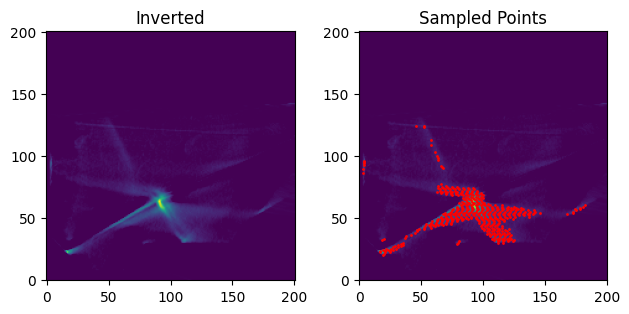

In [6]:
mode = 'L-mode'
skipnum = 4
choose_idx = 20

fig, ax = plt.subplots(1, 2)

r_2 = [r_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
z_2 = [z_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]

# Plot on the first subplot
ax[0].imshow(inverted, origin='lower')
ax[0].set_title('Inverted')

# Plot on the second subplot
ax[1].imshow(inverted, origin='lower')
ax[1].scatter(z_2,r_2, s = 1, c = 'red')
ax[1].set_title('Sampled Points')

plt.tight_layout()
plt.show()


In [7]:
def make_samples(skipnum, inv_dat):
    r_coords, z_coords = np.where(inv_dat['inverted'] > .1)
    if skipnum == 0:
        r_2 = [r_coords[i] for i in range(len(r_coords))]
        z_2 = [z_coords[i] for i in range(len(r_coords))]
    elif skipnum > 0:
        r_2 = [r_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
        z_2 = [z_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
    else:
        assert('skipnum must be a positive integer')
        
    r_loc = inv_dat['r_arr'][r_2]
    z_loc = inv_dat['z_arr'][z_2]
    intensity = inv_dat['inverted'][r_coords, z_coords]
    
    R0s = np.array([r_loc])
    Z0s = np.array([z_loc])
    
    nsample = Z0s.shape[0]
    
    A0s = np.array([intensity])
    M0s = np.ones((nsample,len(intensity))) * 0.001
    
    return R0s, Z0s, A0s, M0s, nsample

def make_setup(skip_num = 0, inv_dat = None):

    save_name= 'synthetic_outers.h5'
    chunk_size = 200
    
    Rinfo = {}
    Rinfo['outfile'], Rinfo['chunk_size'] = save_name, chunk_size
    Rinfo['R0s'], Rinfo['Z0s'], Rinfo['A0s'], Rinfo['M0s'], Rinfo['nsample'] = make_samples(skip_num, inv_dat)

    if Rinfo['nsample'] < Rinfo['chunk_size']:
        Rinfo['chunk_size'] = Rinfo['nsample']
    
    return Rinfo

def make_synthetic(camgeo, inv_dat):
    Rinfo  = make_setup(inv_dat)
    image = cg._integrate_image(Rinfo, 0, camgeo=camgeo)
    image = cv2.convertScaleAbs(np.flip(image * 255, 0), alpha= 1.5, beta = 2)

In [8]:
def _calibrating_indexes(ih=0,camgeo={}):

    # Re-adjustment of vertical pixel index to match the real-image with synthetic image
    coefs= [-5.94*1.e-6,
           +1.87*1.e-3,
           -2.49*1.e-1,
           +2.70*1.e+1]
    y   = 0.
    for k in range(4): y += coefs[k] * (ih ** (3-k))
    y = max(y,15)
    y+= ih
    y = min(y,camgeo['nh']-1)
    return y

def _load_camera(camera_save='Camera_geo.pl',filename1='geom_240perp_unwarp_2022fwd.sav',filename2='cam240perp_geometry_2022.sav'):

    #Load camera geometry

    #camera_save: Post-process camera info
    #filename1:   Camera target RZPhi info
    #filename2:   Camera CCD vertex info    

    camgeo={}    #geometry variables

    if not os.path.isfile(camera_save):

        target = readsav(filename1)
        camgeo['tar_r'] = target['newR'] / 1.e2
        camgeo['tar_z'] = target['newZ'] / 1.e2
        camgeo['tar_p'] = target['newPhi'] / 180*np.pi    

        vertex = readsav(filename2)
        location = vertex.Geom.povray[0][0][0] / 1.e2

        with open(camera_save,'wb') as f: 
            pickle.dump([camgeo['tar_r'],camgeo['tar_z'],camgeo['tar_p'],location],f)
    else:
        with open(camera_save,'rb') as f: 
            [camgeo['tar_r'],camgeo['tar_z'],camgeo['tar_p'],location] = pickle.load(f)

    camgeo['tar_x'] = camgeo['tar_r']  * np.cos(camgeo['tar_p'])
    camgeo['tar_y'] = camgeo['tar_r']  * np.sin(camgeo['tar_p'])

    [camgeo['nh'], camgeo['nw']] = camgeo['tar_x'].shape
    
    pre_ih = []
    new_ih = []
    for ih in range(camgeo['tar_x'].shape[0]):
        pre_ih.append(ih)
        new_ih.append(_calibrating_indexes(ih,camgeo))

    for iw in range(camgeo['tar_x'].shape[1]):

        camgeo['tar_x'][:,iw] = interp1d(pre_ih,camgeo['tar_x'][:,iw])(new_ih)
        camgeo['tar_y'][:,iw] = interp1d(pre_ih,camgeo['tar_y'][:,iw])(new_ih)
        camgeo['tar_z'][:,iw] = interp1d(pre_ih,camgeo['tar_z'][:,iw])(new_ih)
        camgeo['tar_r'][:,iw] = interp1d(pre_ih,camgeo['tar_r'][:,iw])(new_ih)

    camgeo['cam_x']  = np.ones((camgeo['nh'],camgeo['nw'])) * location[0]
    camgeo['cam_y']  = np.ones((camgeo['nh'],camgeo['nw'])) * location[1]
    camgeo['cam_z']  = np.ones((camgeo['nh'],camgeo['nw'])) * location[2]

    camgeo['vec_x'] = camgeo['tar_x']-camgeo['cam_x']
    camgeo['vec_y'] = camgeo['tar_y']-camgeo['cam_y']
    camgeo['vec_z'] = camgeo['tar_z']-camgeo['cam_z']
    camgeo['vec_s'] = np.sqrt(camgeo['vec_x']**2+camgeo['vec_y']**2+camgeo['vec_z']**2)

    camgeo['cam_c'] = np.zeros((camgeo['nh'],camgeo['nw']))

    ih2 = int(camgeo['nh']/2)
    iw2 = int(camgeo['nw']/2)

    for ih in range(camgeo['nh']):
        for iw in range(camgeo['nw']):
            sum0 = 0; sum1 = 0; sum2 = 0;
            for d in ['vec_x','vec_y','vec_z']:
                sum0+= camgeo[d][ih,iw]  *camgeo[d][ih,iw]
                sum1+= camgeo[d][ih2,iw2]*camgeo[d][ih2,iw2]
                sum2+= camgeo[d][ih,iw]  *camgeo[d][ih2,iw2]

            camgeo['cam_c'][ih,iw] = abs(sum2)/np.sqrt(sum0)/np.sqrt(sum1)

    camgeo['inv_x'] = np.linspace(+1.0,+2.0,201)
    camgeo['inv_y'] = np.linspace(-1.4,-0.4,201)
    
    print('>>> Synthetic Camera dim.',camgeo['tar_r'].shape)
    print('>>> Inverted  Camera dim. (%i, %i)'%(camgeo['inv_y'].shape[0],camgeo['inv_x'].shape[0]))
    return camgeo

In [9]:
# Main runs
camgeo = _load_camera(camera_save='../data/external/cam_geo/Camera_geo.pl',
                        filename1='../data/external/cam_geo/geom_240perp_unwarp_2022fwd.sav',
                        filename2='../data/external/cam_geo/cam240perp_geometry_2022.sav')

>>> Synthetic Camera dim. (240, 720)
>>> Inverted  Camera dim. (201, 201)


In [10]:
def _get_emission(camgeo={},M0=0.,R0=0.,Z0=0.,ih=0,iw=0,tt=0.):

    # Make emission from radiating point at tt of LOS to [ih,iw] pixel of camgeo

    xx = camgeo['vec_x'][ih,iw] * tt + camgeo['cam_x'][ih,iw]
    yy = camgeo['vec_y'][ih,iw] * tt + camgeo['cam_y'][ih,iw]
    zz = camgeo['vec_z'][ih,iw] * tt + camgeo['cam_z'][ih,iw]

    rr = np.sqrt(xx**2+yy**2)
    dd = np.sqrt((Z0-zz)**2+(R0-rr)**2)

    return np.exp(-(dd/M0)**3)

In [11]:
def _generate_image(R0=0.,Z0=0.,A0=0.,M0=0.,cam_image=[],cam_inver=[],camgeo={}):

    # Make images by emission ring at (R0,Z0)[m] with A0 amplitude, M0 [m] thickness
    # with camgeo info

    for iw in range(camgeo['cam_x'].shape[1]):
        for ih in range(camgeo['cam_x'].shape[0]):

            # Skip 0.0.0 pixels
            if (camgeo['tar_x'][ih,iw]==0.): continue

            # Location of emission ring along the line of sight (LOS)
            tt = (Z0-camgeo['cam_z'][ih,iw])/camgeo['vec_z'][ih,iw]
            dt =  M0/camgeo['vec_z'][ih,iw]
            # Skip if not on the LOS
            if (tt<0 or tt>1): continue       

            # Find the intersection of line of sight and emission ring
            tot_emission = 0.
            tot_emission += _get_emission(camgeo,M0,R0,Z0,ih,iw,tt+0.5*dt)
            tot_emission += _get_emission(camgeo,M0,R0,Z0,ih,iw,tt)
            tot_emission += _get_emission(camgeo,M0,R0,Z0,ih,iw,tt-0.5*dt)

            ssl  = camgeo['vec_s'][ih,iw] * abs(dt)

            tot_emission = A0 * tot_emission * ssl / 3

            # Accumulate emission on the pixel
            cam_image[ih,iw] += tot_emission

    # Generate inverted image
    for iw in range(camgeo['inv_x'].shape[0]):
        xx= camgeo['inv_x'][iw]
        for ih in range(camgeo['inv_y'].shape[0]):
            yy= camgeo['inv_y'][ih]
            dd = np.sqrt((Z0-yy)**2+(R0-xx)**2)
            cam_inver[ih,iw] += A0 * np.exp(-(dd/M0)**3)

    return cam_image, cam_inver

In [12]:
def _integrate_image(Rinfo={},info_ind=0,camgeo={}):

    # Integrate images of different radiating rings in info_ind-th Rinfo

    R0s   = Rinfo['R0s'][info_ind]
    Z0s   = Rinfo['Z0s'][info_ind]
    A0s   = Rinfo['A0s'][info_ind]
    M0s   = Rinfo['M0s'][info_ind]

    cam_image = np.zeros(camgeo['cam_x'].shape)
    cam_inver = np.zeros((camgeo['inv_y'].shape[0],camgeo['inv_x'].shape[0]))

    if not (len(R0s)==len(Z0s)==len(A0s)==len(M0s)):
        print('>>> Given emission info is wrong!')
        exit()

    print('>>> Case #',Rinfo['nsample'])

    for i,R0 in tqdm(enumerate(R0s)):
        image, inver = _generate_image(R0s[i],Z0s[i],A0s[i],M0s[i],cam_image,cam_inver,camgeo)

        cam_image += image
        cam_inver += inver

    return cam_image, cam_inver

In [13]:
M = 256 # number of pixels
N = 100 # number solution cells
K = 50 # number of test points
D = 1 # chord length
response_mat = D / K * np.zeros((N, M))

In [19]:
print(inverted)
inv_dat = {'r_arr': r_arr, 'z_arr': z_arr,
           'r_coords': r_coords, 'z_coords': z_coords,
           'inverted': inverted,
                               }

Rinfo  = make_setup(inv_dat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TypeError: 'NoneType' object is not subscriptable

In [ ]:
image = _integrate_image(Rinfo, 0, camgeo=camgeo)

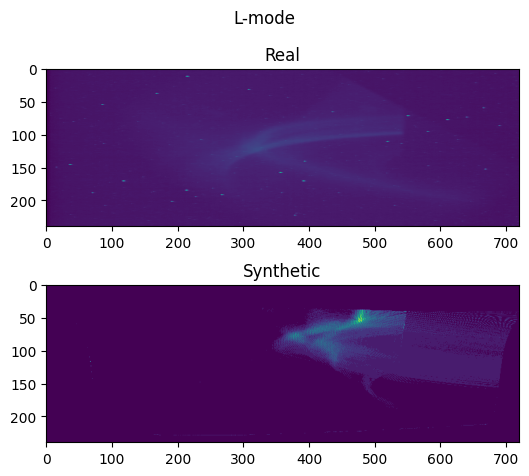

In [85]:
fig, ax = plt.subplots(2,1)
plt.suptitle(mode)
ax[0].imshow(vid)
ax[0].set_title('Real')
ax[1].imshow(image)
ax[1].set_title('Synthetic')
plt.tight_layout()
plt.show()

### Augumented Synthetic

#### Add Noise to Raw Synthetic

In [90]:
def add_noise(image, noise_level = 0.5):
    noise = np.random.normal(0, noise_level, image.shape)
    noisy = image + noise
    return noisy

def add_noise_2(image, noise_factor=0.1):
    image_array = np.array(image) / 255.0
    noise = np.random.normal(loc=0, scale=1, size=image_array.shape)
    noisy_image = image_array + noise_factor * noise
    noisy_image = np.clip(noisy_image, 0, 1)
    return Image.fromarray((noisy_image * 255).astype(np.uint8), mode="L")

def adaptive_noise(image, base_factor=0.1, edge_factor=0.05):
    image_array = np.array(image) / 255.0
    edges = cv2.Canny(image_array, 100, 200)
    noise = np.random.normal(loc=0, scale=1, size=image_array.shape)
    adaptive_factor = np.where(edges > 0, edge_factor, base_factor)
    noisy_image = image_array + adaptive_factor * noise
    return Image.fromarray((np.clip(noisy_image, 0, 1) * 255).astype(np.uint8), mode="L")

In [ ]:
def enhance_contrast(image):
    image_array = np.array(image)
    equalized = cv2.equalizeHist(image_array)
    return Image.fromarray(equalized)

In [ ]:
def multi_scale_refine(image, model, scales=[0.5, 1.0, 1.5]):
    results = []
    for scale in scales:
        scaled_image = image.resize((int(image.width * scale), int(image.height * scale)))
        refined = refine_image(scaled_image, model)
        results.append(refined.resize(image.size))
    return Image.blend(results[0], Image.blend(results[1], results[2], 0.5), 0.5)

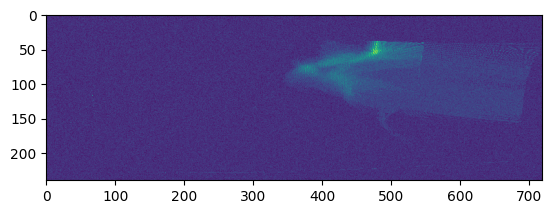

In [91]:
noisy_image = add_noise(image, 0.5)
plt.imshow(noisy_image)

#### Train Diffusion Model on Real Images

#### Augument Synthetic with Diffusion

In [ ]:
class MonochromeStableDiffusion(StableDiffusionImg2ImgPipeline):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Modify the first layer to accept single-channel input
        self.unet.conv_in = torch.nn.Conv2d(1, self.unet.conv_in.out_channels, kernel_size=3, padding=1)

In [ ]:
class GrayscalePerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = torchvision.models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg[x])
        
    def forward(self, input, target):
        input_gray = 0.299 * input[:, 0] + 0.587 * input[:, 1] + 0.114 * input[:, 2]
        target_gray = 0.299 * target[:, 0] + 0.587 * target[:, 1] + 0.114 * target[:, 2]
        h_x = self.slice1(input_gray.unsqueeze(1).repeat(1, 3, 1, 1))
        h_y = self.slice1(target_gray.unsqueeze(1).repeat(1, 3, 1, 1))
        return torch.mean((h_x - h_y) ** 2)

In [ ]:
grayscale_augmentations = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
])

In [ ]:
def prepare_grayscale_dataset(image_folder):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    return datasets.ImageFolder(image_folder, transform=transform)

# Use this dataset for fine-tuning your model

In [ ]:
def gradient_loss(pred, target):
    pred_grad_x = pred[:, :, 1:] - pred[:, :, :-1]
    pred_grad_y = pred[:, 1:, :] - pred[:, :-1, :]
    target_grad_x = target[:, :, 1:] - target[:, :, :-1]
    target_grad_y = target[:, 1:, :] - target[:, :-1, :]
    return F.l1_loss(pred_grad_x, target_grad_x) + F.l1_loss(pred_grad_y, target_grad_y)

In [ ]:
# Main pipeline
def image_refinement_pipeline(input_image_path, model_path, output_image_path):
    # Load the synthetic image
    synthetic_image = load_image(input_image_path)
    
    # Add noise to the synthetic image
    noisy_image = add_noise(synthetic_image, noise_factor=0.1)
    
    # Load the fine-tuned diffusion model
    model = StableDiffusionImg2ImgPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")
    
    # Refine the noisy image
    refined_image = refine_image(noisy_image, model)
    
    # Save the result
    refined_image.save(output_image_path)

# Example usage
input_image_path = "path/to/synthetic_image.png"
model_path = "path/to/fine_tuned_diffusion_model"
output_image_path = "path/to/refined_image.png"

image_refinement_pipeline(input_image_path, model_path, output_image_path)

### Save Synthetic Datasets

### Train Real

### Train Synthetic

## Testing

### Visual Benchmark

### Accuracy Scores